In [1]:
!pip install transformers diffusers ftfy accelerate

In [2]:
import os
import torch
from tqdm import tqdm
from PIL import Image
import torch.nn.functional as F
from torchvision import transforms as tfms
from transformers import CLIPTextModel, CLIPTokenizer, logging
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel

In [3]:
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [5]:
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

In [6]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [7]:
# Access the embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer # Vocab size 49408, emb_dim 768

Embedding(49408, 768)

In [8]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

In [9]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)
position_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [10]:

def build_causal_attention_mask(bsz, seq_len, dtype):
    mask = torch.empty(bsz, seq_len, seq_len, dtype=dtype)
    mask.fill_(torch.tensor(torch.finfo(dtype).min))  # fill with large negative number (acts like -inf)
    mask = mask.triu_(1)  # zero out the lower diagonal to enforce causality
    return mask.unsqueeze(1)  # add a batch dimension

In [11]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

In [12]:
def generate_with_embs(text_embeddings,text_input):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

In [13]:
illustration_style_embeds = torch.load('illustration_style_learned_embeds.bin')
illustration_style_embeds.keys(), illustration_style_embeds['<illustration-style>'].shape

<ipython-input-13-d2fa1748f0c5>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  illustration_style_embeds = torch.load('illustration_style_learned_embeds.bin')


(dict_keys(['<illustration-style>']), torch.Size([768]))

In [14]:
hitokomoru_style_embeds = torch.load('hitokomoru_style_learned_embeds.bin')
hitokomoru_style_embeds.keys(), hitokomoru_style_embeds['<hitokomoru-style>'].shape

<ipython-input-14-83458519dee1>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hitokomoru_style_embeds = torch.load('hitokomoru_style_learned_embeds.bin')


(dict_keys(['<hitokomoru-style>']), torch.Size([768]))

In [15]:
conner_fawcett_style_embeds = torch.load('conner_fawcett_style_learned_embeds.bin')
conner_fawcett_style_embeds.keys(), conner_fawcett_style_embeds['<badbucket>'].shape

<ipython-input-15-fb84fd483491>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  conner_fawcett_style_embeds = torch.load('conner_fawcett_style_learned_embeds.bin')


(dict_keys(['<badbucket>']), torch.Size([768]))

In [16]:
dishonored_portrait_style_embeds = torch.load('dishonored_portrait_style_learned_embeds.bin')
dishonored_portrait_style_embeds.keys(), dishonored_portrait_style_embeds['<portrait-style-dishonored>'].shape

<ipython-input-16-04a43b2f4441>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dishonored_portrait_style_embeds = torch.load('dishonored_portrait_style_learned_embeds.bin'

(dict_keys(['<portrait-style-dishonored>']), torch.Size([768]))

In [17]:
sakimi_style_embeds = torch.load('sakimi_style_learned_embeds.bin')
sakimi_style_embeds.keys(), sakimi_style_embeds['<sakimi>'].shape

<ipython-input-17-1d4338ac4e3b>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sakimi_style_embeds = torch.load('sakimi_style_learned_embeds.bin')


(dict_keys(['<sakimi>']), torch.Size([768]))

In [18]:

tokenizer.add_tokens(['<illustration-style>', '<hitokomoru-style>', '<badbucket>', '<portrait-style-dishonored>', '<sakimi>'])

5

In [19]:
token_emb_layer.state_dict()['weight'].size()

torch.Size([49408, 768])

In [20]:
token_emb_layer_with_art = torch.nn.Embedding(49413, 768)
token_emb_layer_with_art.load_state_dict({'weight': torch.cat((token_emb_layer.state_dict()['weight'],
                                              illustration_style_embeds['<illustration-style>'].unsqueeze(0).to(torch_device),
                                              hitokomoru_style_embeds['<hitokomoru-style>'].unsqueeze(0).to(torch_device),
                                              conner_fawcett_style_embeds['<badbucket>'].unsqueeze(0).to(torch_device),
                                              dishonored_portrait_style_embeds['<portrait-style-dishonored>'].unsqueeze(0).to(torch_device),
                                              sakimi_style_embeds['<sakimi>'].unsqueeze(0).to(torch_device)))})
token_emb_layer_with_art = token_emb_layer_with_art.to(torch_device)

In [21]:
token_emb_layer_with_art.state_dict()['weight'].size()

torch.Size([49413, 768])

In [22]:
def generate_with_prompt_style_guidance(prompt):
  prompt = prompt

  # Tokenize
  text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  input_ids = text_input.input_ids.to(torch_device)

  # Get token embeddings
  token_embeddings = token_emb_layer_with_art(input_ids)

  # Combine with pos embs
  input_embeddings = token_embeddings + position_embeddings

  #  Feed through to get final output embs
  modified_output_embeddings = get_output_embeds(input_embeddings)

  # And generate an image with this:
  image = generate_with_embs(modified_output_embeddings,text_input)
  return image,text_input,input_ids,token_embeddings,modified_output_embeddings

In [23]:
grayscale_transformer = tfms.Grayscale(num_output_channels=3)

In [24]:
def guide_loss(images, loss_type='grayscale'):
    # grayscale loss
    if loss_type == 'grayscale':
      transformed_imgs = grayscale_transformer(images)
      error = torch.abs(transformed_imgs - images).mean()

    # brightness loss
    elif loss_type == 'bright':
      transformed_imgs = tfms.functional.adjust_brightness(images, brightness_factor=3)
      error = torch.abs(transformed_imgs - images).mean()
    return error

In [33]:
def generate_with_prompt_style_guidance_with_loss(prompt):
  # Tokenize
  prompt = prompt
  image,text_input,input_ids,token_embeddings,modified_output_embeddings = generate_with_prompt_style_guidance(prompt)
  height = 512                        # default height of Stable Diffusion
  width = 512                         # default width of Stable Diffusion
  num_inference_steps = 50        # Number of denoising steps
  guidance_scale = 8           # Scale for classifier-free guidance
  generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
  batch_size = 1
  loss_scale = 100

  # And the uncond. input as before:
  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
  )
  with torch.no_grad():
      uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
  text_embeddings = torch.cat([uncond_embeddings, modified_output_embeddings])

  # Prep Scheduler
  set_timesteps(scheduler, num_inference_steps)

  # Prep latents
  latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
  )
  latents = latents.to(torch_device)
  latents = latents * scheduler.init_noise_sigma

  # Loop
  for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
      # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
      latent_model_input = torch.cat([latents] * 2)
      sigma = scheduler.sigmas[i]
      latent_model_input = scheduler.scale_model_input(latent_model_input, t)

      # predict the noise residual
      with torch.no_grad():
          noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

      # perform CFG
      noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
      noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

      #### ADDITIONAL GUIDANCE ###
      if i%5 == 0:
          # Requires grad on the latents
          latents = latents.detach().requires_grad_()

          # Get the predicted x0:
          latents_x0 = latents - sigma * noise_pred
          # latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

          # Decode to image space
          denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

          # Calculate loss
          loss = guide_loss(denoised_images, 'grayscale') * loss_scale

          # Occasionally print it out
          if i%10==0:
              print(i, 'loss:', loss.item())

          # Get gradient
          cond_grad = torch.autograd.grad(loss, latents)[0]

          # Modify the latents based on this gradient
          latents = latents.detach() - cond_grad * sigma**2

      # Now step with scheduler
      latents = scheduler.step(noise_pred, t, latents).prev_sample


  return latents_to_pil(latents)[0]

<ipython-input-12-c39cad9a4d3d>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
100%|██████████| 30/30 [00:14<00:00,  2.04it/s]
<ipython-input-33-6e949b9f193e>:27: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 12.273590087890625


 22%|██▏       | 11/50 [00:08<00:36,  1.08it/s]

10 loss: 4.6609601974487305


 42%|████▏     | 21/50 [00:16<00:26,  1.08it/s]

20 loss: 2.16363787651062


 62%|██████▏   | 31/50 [00:23<00:17,  1.09it/s]

30 loss: 2.040853500366211


 82%|████████▏ | 41/50 [00:31<00:08,  1.11it/s]

40 loss: 1.7600841522216797


100%|██████████| 50/50 [00:36<00:00,  1.35it/s]


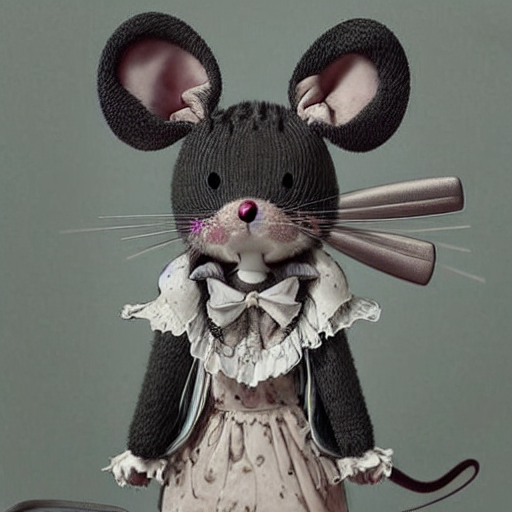

In [34]:
generate_with_prompt_style_guidance_with_loss('A mouse in the style of <hitokomoru-style>')

<ipython-input-12-c39cad9a4d3d>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
100%|██████████| 30/30 [00:14<00:00,  2.12it/s]
<ipython-input-33-6e949b9f193e>:27: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  2%|▏         | 1/50 [00:01<00:50,  1.03s/it]

0 loss: 7.758124351501465


 22%|██▏       | 11/50 [00:08<00:35,  1.11it/s]

10 loss: 2.1103768348693848


 42%|████▏     | 21/50 [00:15<00:26,  1.09it/s]

20 loss: 3.4189159870147705


 62%|██████▏   | 31/50 [00:23<00:17,  1.07it/s]

30 loss: 1.4803314208984375


 82%|████████▏ | 41/50 [00:30<00:08,  1.09it/s]

40 loss: 1.6396671533584595


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


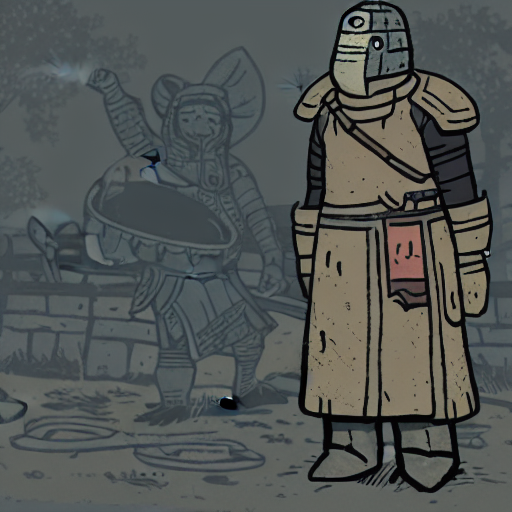

In [35]:
generate_with_prompt_style_guidance_with_loss('A mouse in the style of <badbucket>')

<ipython-input-12-c39cad9a4d3d>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
100%|██████████| 30/30 [00:14<00:00,  2.06it/s]
<ipython-input-33-6e949b9f193e>:27: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  2%|▏         | 1/50 [00:01<00:52,  1.07s/it]

0 loss: 31.514772415161133


 22%|██▏       | 11/50 [00:08<00:35,  1.09it/s]

10 loss: 8.329882621765137


 42%|████▏     | 21/50 [00:16<00:26,  1.08it/s]

20 loss: 7.115509986877441


 62%|██████▏   | 31/50 [00:23<00:17,  1.10it/s]

30 loss: 6.0525221824646


 82%|████████▏ | 41/50 [00:30<00:08,  1.12it/s]

40 loss: 6.170053958892822


100%|██████████| 50/50 [00:36<00:00,  1.36it/s]


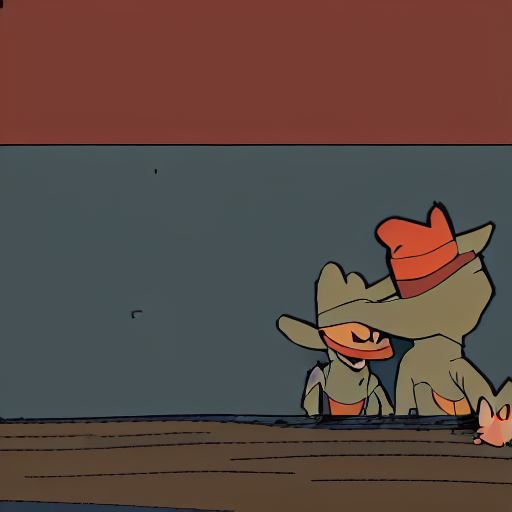

In [36]:
generate_with_prompt_style_guidance_with_loss('A mouse in the style of <illustration-style>')

<ipython-input-12-c39cad9a4d3d>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
100%|██████████| 30/30 [00:14<00:00,  2.09it/s]
<ipython-input-33-6e949b9f193e>:27: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  2%|▏         | 1/50 [00:01<00:49,  1.01s/it]

0 loss: 13.342634201049805


 22%|██▏       | 11/50 [00:08<00:33,  1.16it/s]

10 loss: 1.4581700563430786


 42%|████▏     | 21/50 [00:15<00:25,  1.16it/s]

20 loss: 0.5838128924369812


 62%|██████▏   | 31/50 [00:22<00:16,  1.15it/s]

30 loss: 0.4622376561164856


 82%|████████▏ | 41/50 [00:29<00:07,  1.14it/s]

40 loss: 0.41024306416511536


100%|██████████| 50/50 [00:35<00:00,  1.42it/s]


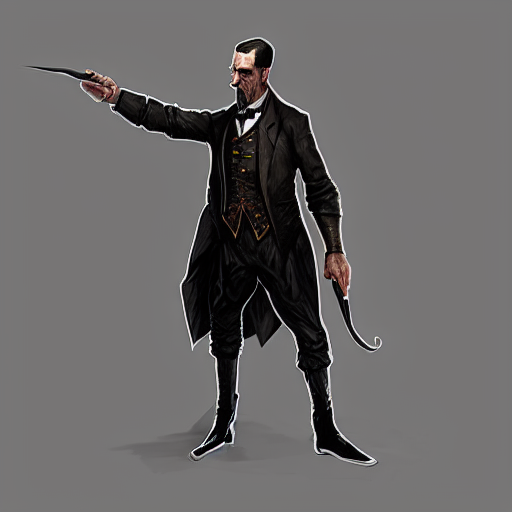

In [37]:
generate_with_prompt_style_guidance_with_loss('A mouse in the style of <portrait-style-dishonored>')

<ipython-input-12-c39cad9a4d3d>:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
100%|██████████| 30/30 [00:14<00:00,  2.05it/s]
<ipython-input-33-6e949b9f193e>:27: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
  2%|▏         | 1/50 [00:01<00:50,  1.04s/it]

0 loss: 18.637388229370117


 22%|██▏       | 11/50 [00:08<00:34,  1.12it/s]

10 loss: 2.592276096343994


 42%|████▏     | 21/50 [00:15<00:25,  1.13it/s]

20 loss: 2.3837361335754395


 62%|██████▏   | 31/50 [00:22<00:16,  1.13it/s]

30 loss: 1.9478485584259033


 82%|████████▏ | 41/50 [00:29<00:07,  1.14it/s]

40 loss: 2.0692217350006104


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


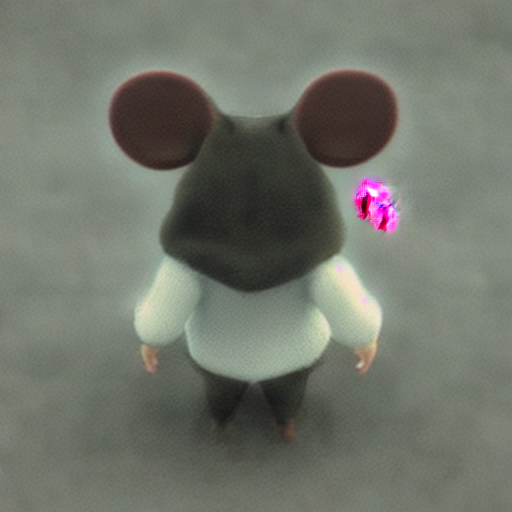

In [38]:
generate_with_prompt_style_guidance_with_loss('A mouse in the style of <sakimi>')